In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 26.5 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.75
batch_size_value = 32
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
# noise = 'salt&pepper'
noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 1s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:00<00:00, 34440.23it/s]



salt&pepper noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 29793.32it/s]


salt&pepper noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

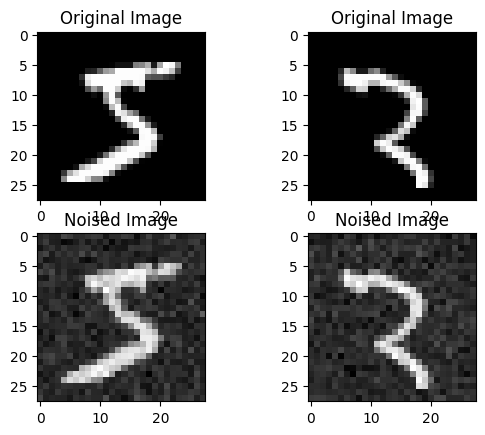

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

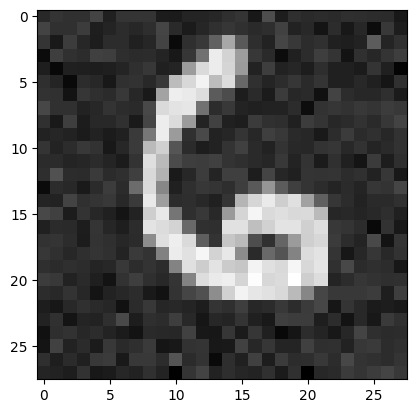

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

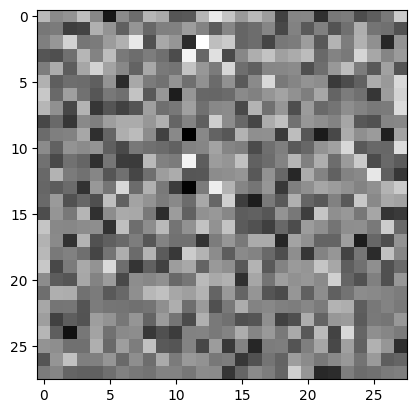

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(957.4922, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2291.239501953125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000, -0.0156, -0.0156,  ...,  0.0156,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0156,  0.0000, -0.0156],
        [-0.0156,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, -0.0156,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0156,  ...,  0.0000,  0.0156,  0.0000],
        [ 0.0000,  0.0000, -0.0156,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 313/313 [02:08<00:00,  2.44it/s]


  0 3533.7664 1305.3868


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


  1 2243.3782 1123.8816


100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


  2 1975.8945 1068.9705


100%|██████████| 313/313 [02:13<00:00,  2.34it/s]


  3 1855.1262 1037.6646


100%|██████████| 313/313 [02:07<00:00,  2.45it/s]


  4 1782.7333 1019.2631


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


  5 1732.5854 1003.4067


100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


  6 1700.8439 991.3622


100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


  7 1674.3109 984.2092


100%|██████████| 313/313 [02:11<00:00,  2.39it/s]


  8 1653.1260 974.2191


100%|██████████| 313/313 [02:08<00:00,  2.44it/s]


  9 1638.5817 967.4272


100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


 10 1622.9291 961.4267


100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


 11 1610.3025 956.4818


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


 12 1596.2043 951.9968


100%|██████████| 313/313 [02:11<00:00,  2.38it/s]


 13 1585.0471 946.8463


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


 14 1576.6416 944.2557


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


 15 1563.5157 939.6588


100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


 16 1556.1464 936.7622


100%|██████████| 313/313 [01:55<00:00,  2.71it/s]


 17 1547.2815 936.2286


100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


 18 1538.3700 932.2216


100%|██████████| 313/313 [01:53<00:00,  2.77it/s]


 19 1530.1783 930.3036


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


 20 1523.8401 927.5193


100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


 21 1515.3290 925.1829


100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


 22 1508.0836 922.4178


100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


 23 1502.5012 920.8932


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 24 1495.2528 918.4042


100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


 25 1490.3950 917.9351


100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


 26 1485.7388 916.2728


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


 27 1480.3292 914.0887


100%|██████████| 313/313 [01:55<00:00,  2.72it/s]


 28 1474.2932 913.4158


100%|██████████| 313/313 [01:55<00:00,  2.70it/s]


 29 1468.7913 912.1611


100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


 30 1465.2148 910.1494


100%|██████████| 313/313 [01:52<00:00,  2.77it/s]


 31 1458.8730 907.7994


100%|██████████| 313/313 [01:54<00:00,  2.72it/s]


 32 1457.6404 909.6158


100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


 33 1451.9663 907.7948


100%|██████████| 313/313 [01:55<00:00,  2.71it/s]


 34 1446.8239 905.8245


100%|██████████| 313/313 [01:54<00:00,  2.75it/s]


 35 1443.5748 904.4513


100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


 36 1440.1686 903.2322


100%|██████████| 313/313 [01:52<00:00,  2.78it/s]


 37 1436.2161 903.7170


100%|██████████| 313/313 [01:54<00:00,  2.73it/s]


 38 1435.1528 903.5775


100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


 39 1431.5145 900.8976


100%|██████████| 313/313 [01:55<00:00,  2.72it/s]


 40 1426.2871 899.9792


100%|██████████| 313/313 [01:55<00:00,  2.72it/s]


 41 1425.4181 899.7386


100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


 42 1420.5178 897.6825


100%|██████████| 313/313 [01:53<00:00,  2.77it/s]


 43 1416.7300 897.5381


100%|██████████| 313/313 [01:54<00:00,  2.73it/s]


 44 1415.7246 896.4529


100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


 45 1412.6394 894.7376


100%|██████████| 313/313 [02:11<00:00,  2.38it/s]


 46 1410.9949 894.2800


100%|██████████| 313/313 [02:08<00:00,  2.43it/s]


 47 1408.3177 895.9521


100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


 48 1404.5062 893.0007


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


 49 1403.6797 893.5333

  2 MSE    Topo  


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


  0 3585.0828 1323.0392


100%|██████████| 313/313 [02:10<00:00,  2.39it/s]


  1 2277.1750 1133.8558


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


  2 1994.1494 1075.9950


100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


  3 1861.0183 1044.3081


100%|██████████| 313/313 [01:58<00:00,  2.65it/s]


  4 1786.9301 1023.9630


100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


  5 1732.6746 1006.9922


100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


  6 1698.9860 994.1132


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


  7 1675.9257 985.4543


100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


  8 1657.0956 978.8416


100%|██████████| 313/313 [02:01<00:00,  2.57it/s]


  9 1642.1306 971.5931


100%|██████████| 313/313 [02:08<00:00,  2.44it/s]


 10 1627.5789 964.4998


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


 11 1611.7083 959.4349


100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


 12 1602.5751 954.0022


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


 13 1590.2015 951.3645


100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


 14 1578.9279 946.7299


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


 15 1569.4056 942.9913


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


 16 1558.9698 939.8077


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


 17 1549.8599 938.1041


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


 18 1543.1777 935.3684


100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


 19 1534.8895 933.1005


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


 20 1526.3567 928.6603


100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


 21 1519.3718 928.6976


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


 22 1513.0393 927.8914


100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


 23 1506.5150 924.0262


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


 24 1501.1276 923.2194


100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


 25 1493.2179 921.1973


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 26 1486.7245 918.5920


100%|██████████| 313/313 [02:15<00:00,  2.31it/s]


 27 1481.8910 917.5198


100%|██████████| 313/313 [02:13<00:00,  2.34it/s]


 28 1474.9208 916.4135


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


 29 1469.5399 916.3808


100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


 30 1464.6104 914.4039


100%|██████████| 313/313 [02:14<00:00,  2.33it/s]


 31 1460.1151 911.7450


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


 32 1457.0603 912.3743


100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


 33 1449.2262 907.9631


100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


 34 1446.8785 908.6613


100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


 35 1442.2434 907.1073


100%|██████████| 313/313 [02:16<00:00,  2.30it/s]


 36 1439.4274 906.1107


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


 37 1433.4089 904.6332


100%|██████████| 313/313 [02:01<00:00,  2.57it/s]


 38 1429.5167 902.7416


100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


 39 1429.0483 904.2853


100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


 40 1424.6438 901.6698


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


 41 1421.6392 901.5837


100%|██████████| 313/313 [02:07<00:00,  2.45it/s]


 42 1420.6642 901.8738


100%|██████████| 313/313 [02:08<00:00,  2.44it/s]


 43 1415.8090 900.0813


100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


 44 1413.7137 899.9353


100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


 45 1410.0270 896.9211


100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


 46 1408.3795 896.5018


100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


 47 1404.2528 896.4493


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


 48 1401.5074 895.8833


100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


 49 1402.0012 896.0212

  3 MSE    Topo  


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


  0 3496.8403 1307.2482


100%|██████████| 313/313 [02:08<00:00,  2.43it/s]


  1 2234.3311 1122.8612


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


  2 1968.3666 1066.4266


100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


  3 1840.1134 1035.9241


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


  4 1767.1382 1015.4203


100%|██████████| 313/313 [02:13<00:00,  2.35it/s]


  5 1714.4940 998.5328


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


  6 1679.6398 988.6730


100%|██████████| 313/313 [02:08<00:00,  2.44it/s]


  7 1655.7939 980.6172


100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


  8 1635.7908 972.1402


100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


  9 1615.4716 963.6533


100%|██████████| 313/313 [01:55<00:00,  2.71it/s]


 10 1601.1096 960.1759


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 11 1585.6310 952.7294


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


 12 1575.2905 950.2040


100%|██████████| 313/313 [02:16<00:00,  2.30it/s]


 13 1561.4071 944.7590


100%|██████████| 313/313 [02:13<00:00,  2.34it/s]


 14 1552.7366 941.4091


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


 15 1542.0566 939.1364


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


 16 1533.7676 934.6063


100%|██████████| 313/313 [02:45<00:00,  1.90it/s]


 17 1524.1647 932.4620


100%|██████████| 313/313 [02:19<00:00,  2.25it/s]


 18 1519.5886 932.1975


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


 19 1511.9905 928.9373


100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


 20 1502.9843 926.4289


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 21 1497.5917 924.4144


100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


 22 1488.3575 921.4463


100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


 23 1485.4130 919.9615


100%|██████████| 313/313 [02:10<00:00,  2.39it/s]


 24 1481.1929 919.5673


100%|██████████| 313/313 [02:11<00:00,  2.37it/s]


 25 1474.4641 918.4299


100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


 26 1469.0721 915.0508


100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


 27 1465.8428 914.6991


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 28 1461.9049 914.4552


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 29 1456.9526 910.2346


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 30 1450.7618 908.0614


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


 31 1449.5140 908.9807


100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


 32 1442.7787 905.9022


100%|██████████| 313/313 [01:58<00:00,  2.63it/s]


 33 1440.3927 904.7041


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


 34 1437.3920 905.5336


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


 35 1434.2325 903.8351


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


 36 1430.0087 904.1088


100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


 37 1426.7113 900.5621


100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


 38 1424.0736 899.8558


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


 39 1422.3839 899.3725


100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


 40 1418.4821 898.8935


100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


 41 1414.7592 898.7769


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 42 1413.7500 896.3367


100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 43 1409.2373 896.3880


100%|██████████| 313/313 [01:58<00:00,  2.65it/s]


 44 1406.0829 894.9819


100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


 45 1404.7157 894.3995


100%|██████████| 313/313 [01:58<00:00,  2.63it/s]


 46 1402.3756 893.2161


100%|██████████| 313/313 [01:58<00:00,  2.65it/s]


 47 1400.9351 894.2334


100%|██████████| 313/313 [01:58<00:00,  2.63it/s]


 48 1398.0978 891.2475


100%|██████████| 313/313 [01:56<00:00,  2.68it/s]

 49 1395.2936 890.0593

CPU times: user 8h 44min 35s, sys: 1min 17s, total: 8h 45min 53s
Wall time: 5h 8min 11s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

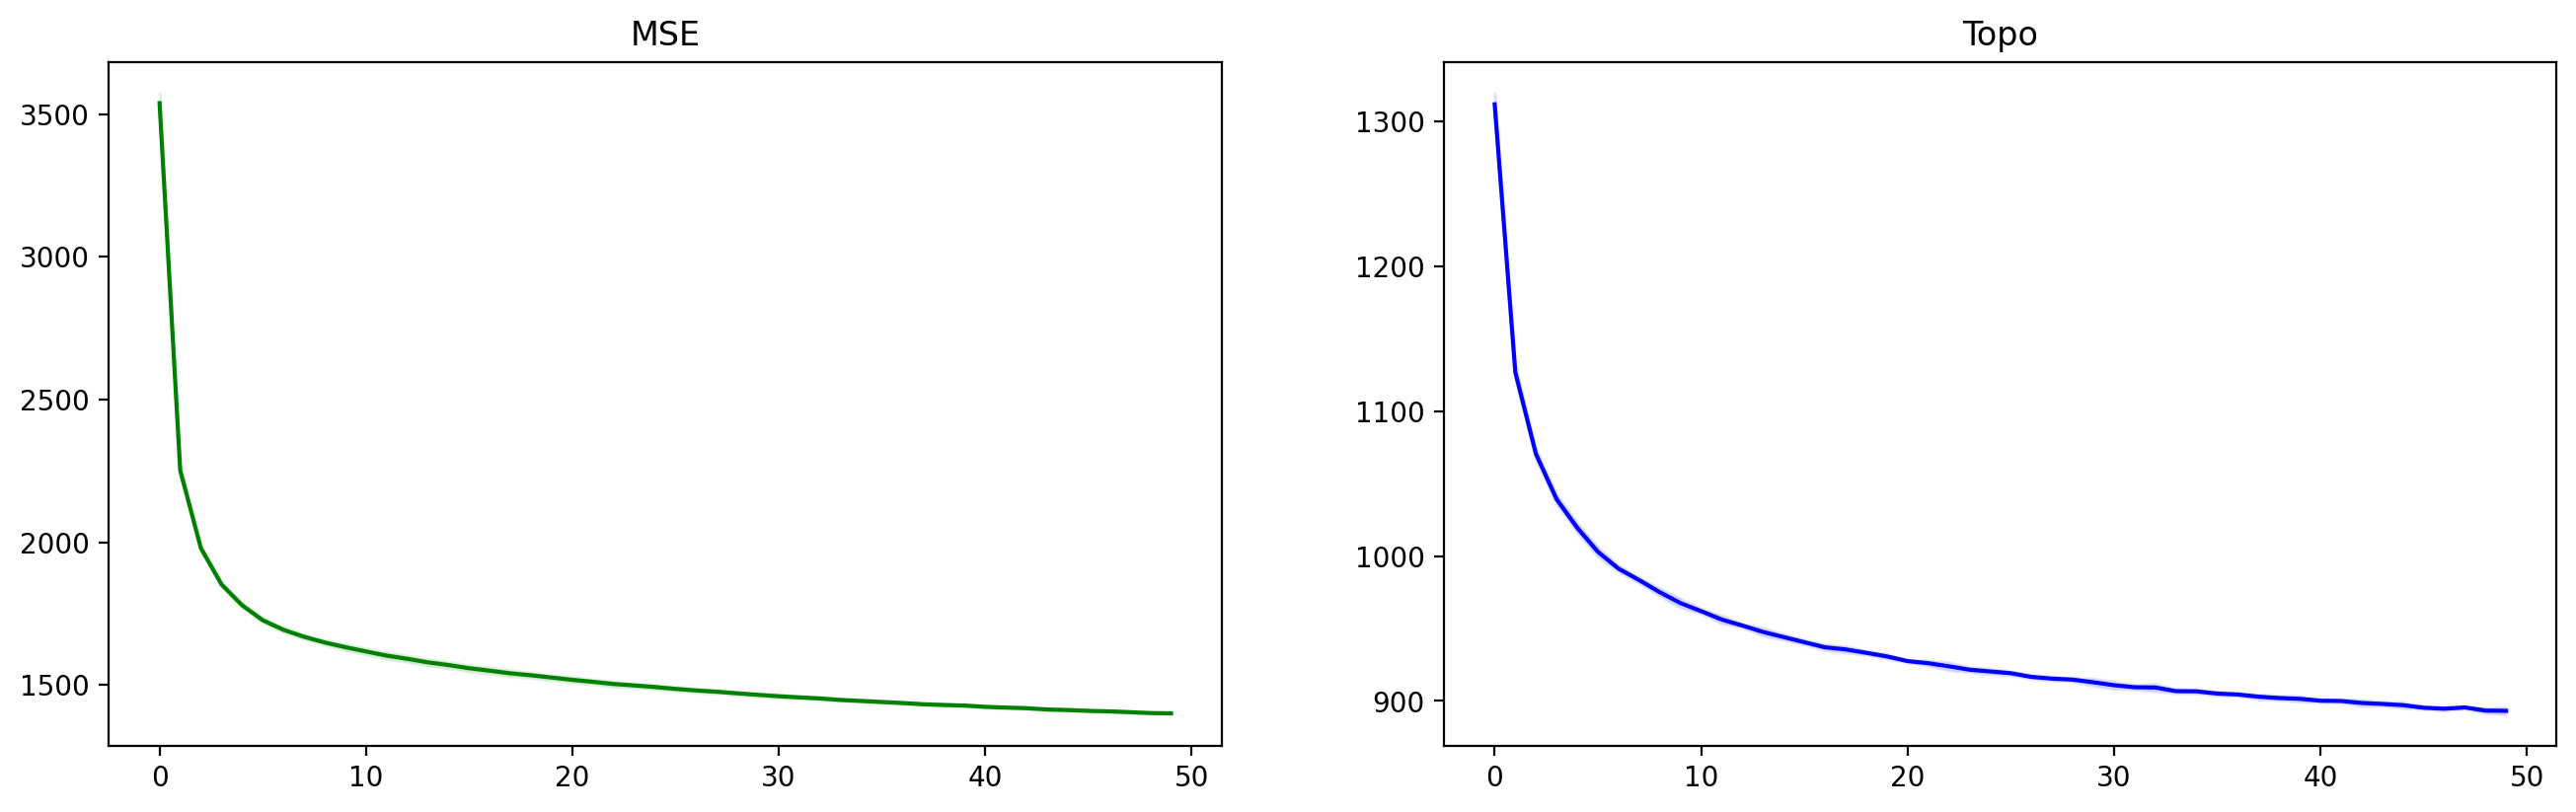

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

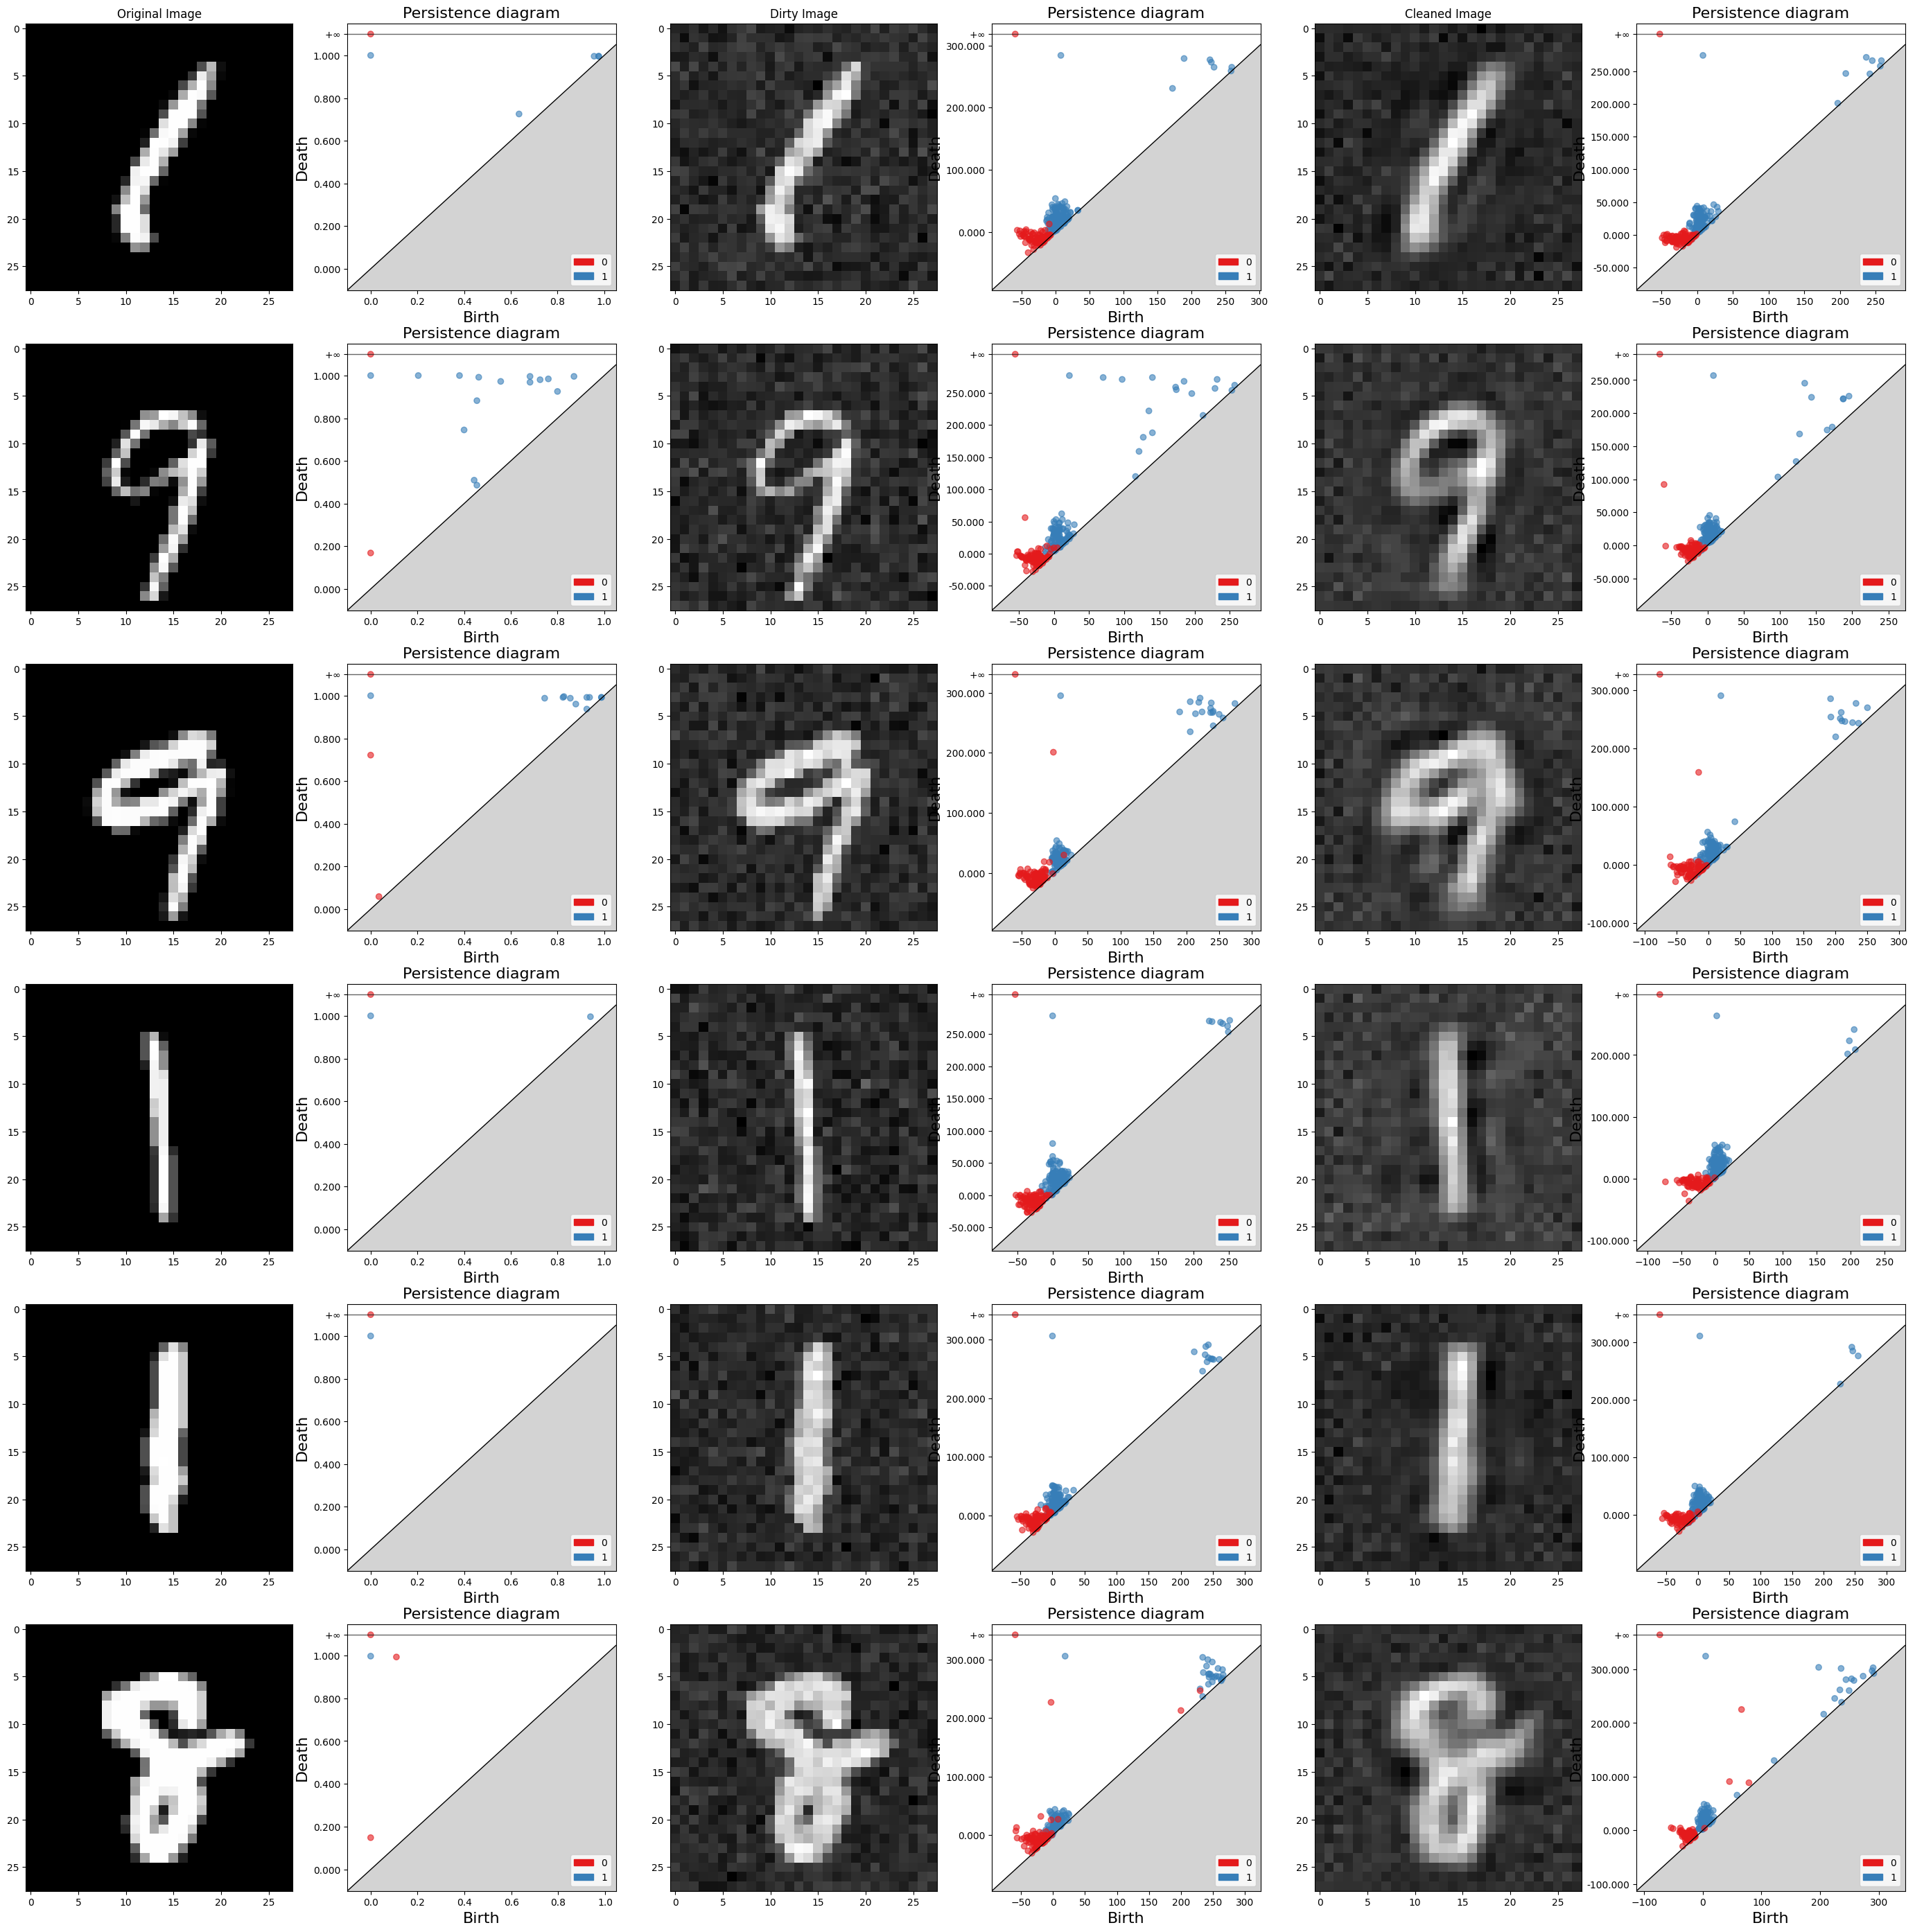

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[3533.76635742 1305.38684082]
  [2243.37817383 1123.8815918 ]
  [1975.89453125 1068.97045898]
  [1855.1262207  1037.66455078]
  [1782.73327637 1019.26306152]
  [1732.58544922 1003.40673828]
  [1700.84387207  991.36224365]
  [1674.31091309  984.20916748]
  [1653.12597656  974.21905518]
  [1638.58166504  967.42724609]
  [1622.92907715  961.42669678]
  [1610.30249023  956.48175049]
  [1596.2043457   951.99682617]
  [1585.04711914  946.84625244]
  [1576.64160156  944.25567627]
  [1563.51574707  939.65875244]
  [1556.1463623   936.76220703]
  [1547.28149414  936.2286377 ]
  [1538.36999512  932.22161865]
  [1530.17834473  930.30358887]
  [1523.84008789  927.51928711]
  [1515.32897949  925.18292236]
  [1508.08361816  922.41784668]
  [1502.5012207   920.89324951]
  [1495.25280762  918.4041748 ]
  [1490.39501953  917.93511963]
  [1485.73876953  916.27276611]
  [1480.32922363  914.08874512]
  [1474.29321289  913.41583252]
  [1468.79125977  912.16113281]
  [1465.21484375  910.14935303]
  [1458.